# Import libraries

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Link your Google Drive to Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/electric_field_data.csv")

df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,x,y,E
0,-5.000000,-5.0,0.296945
1,-4.898990,-5.0,0.307085
2,-4.797980,-5.0,0.317555
3,-4.696970,-5.0,0.328350
4,-4.595960,-5.0,0.339465
5,-4.494949,-5.0,0.350887
6,-4.393939,-5.0,0.362605
7,-4.292929,-5.0,0.374598
8,-4.191919,-5.0,0.386844
9,-4.090909,-5.0,0.399312


# Visualize the data

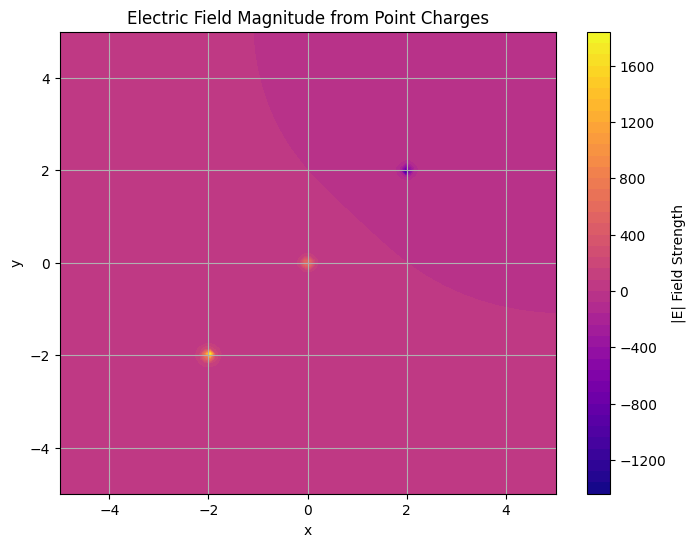

In [3]:
X = df['x'].values.reshape(100, 100)
Y = df['y'].values.reshape(100, 100)
E = df['E'].values.reshape(100, 100)

plt.figure(figsize=(8, 6))
contour = plt.contourf(X,Y,E, levels=50, cmap='plasma')
plt.colorbar(contour, label='|E| Field Strength')
plt.title('Electric Field Magnitude from Point Charges')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Apply DBSCAN Clustering

- Flatten the 2D coordinate grids X and Y into 1D arrays, then stack them vertically
- to create an array of (x, y) position pairs for each measurement point.

In [4]:
positions = np.vstack([X.ravel(), Y.ravel()]).T

- Flatten the electric field magnitude array E into a 1D array, then reshape it
- into a 2D column vector so it can be concatenated as a feature.


In [5]:
fields = E.ravel().reshape(-1, 1)

- Horizontally stack the position coordinates and field values into a single feature array.
- Each row corresponds to one data point: [x, y, |E|]


In [6]:
features = np.hstack([positions, fields])

- Initialize a StandardScaler to normalize the feature values to have mean=0 and variance=1.


In [7]:
scaler = StandardScaler()

- Fit the scaler to the features and transform them, producing scaled features.
- Scaling ensures that all features contribute equally to distance calculations.


In [8]:
features_scaled = scaler.fit_transform(features)


- Initialize the DBSCAN clustering algorithm with parameters:
 - eps=0.3: maximum distance between points to be considered neighbors
 - min_samples=10: minimum number of points required to form a dense cluster
d

In [9]:
db = DBSCAN(eps=0.2, min_samples=5)

- Fit DBSCAN to the scaled feature data and predict cluster labels for each point.
- The result is an array of labels where points in the same cluster have the same label,
- and noise points are labeled as -1.

In [10]:
labels = db.fit_predict(features_scaled)


### Key Learning Goals for Students:

1. **Understanding Unsupervised Clustering in Physics Context**
   They should see how an unsupervised algorithm groups spatial points that exhibit similar field behavior — potentially revealing **hidden structures** (like point charges).

2. **Clusters Correspond to Physical Sources**
   Ideally, clusters highlight regions near each **point charge** where the electric field is strong and spatially coherent.

   * Students can relate clusters to the **locations of underlying charges**.
   * They can observe how the algorithm groups high-field areas separate from the background.

3. **Noise Points as Background or Weak Field Areas**
   Points not assigned to any cluster (`label = -1`) represent areas with weak or ambiguous field values—effectively treated as noise or background.

4. **Parameter Sensitivity and Cluster Shape**
   Students can discuss how DBSCAN parameters (`eps`, `min_samples`) affect cluster size, shape, and noise points. This links machine learning hyperparameters to physical interpretation.

5. **Multi-Dimensional Features for Clustering**
   They understand the importance of including both **spatial coordinates and field magnitude** as features, showing how position alone or field alone might not reveal the full structure.


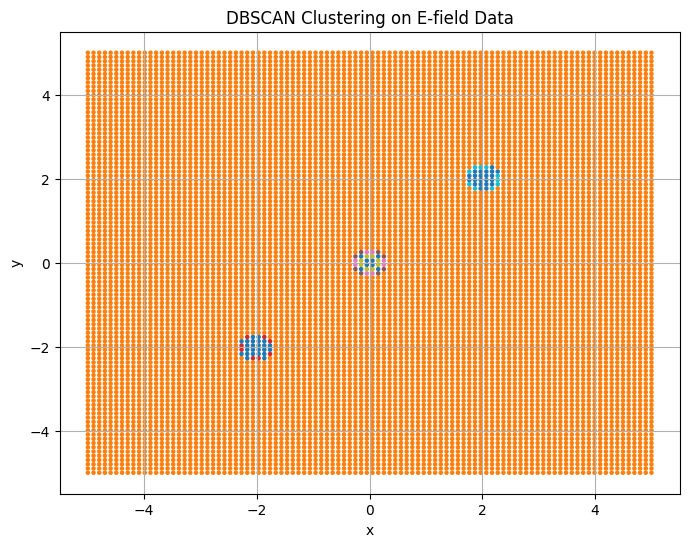

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X.ravel(), Y.ravel(), c=labels, cmap='tab10', s=5)
plt.title('DBSCAN Clustering on E-field Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


# PCA for Dimensionality Reduction

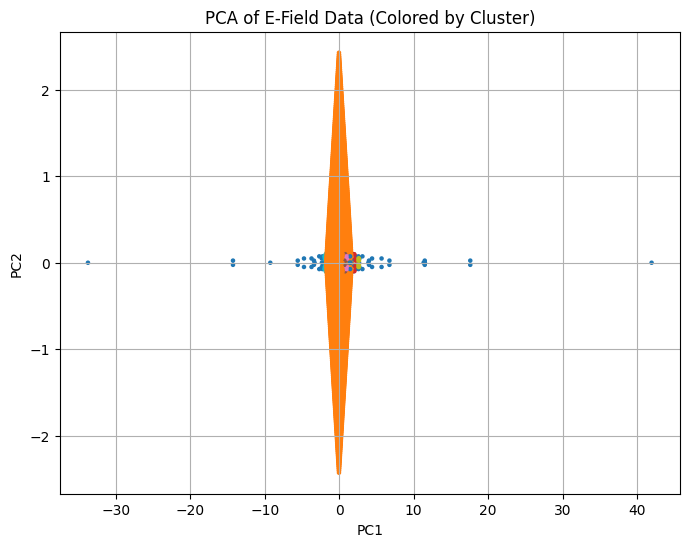

In [12]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='tab10', s=5)
plt.title('PCA of E-Field Data (Colored by Cluster)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

### What You Should Learn / Understand:

1. **Data Visualization in Lower Dimensions:**
   PCA helps **compress information** into 2 dimensions that capture the **most variance** in the data, making it easier to visualize complex relationships.

2. **Cluster Separation in Feature Space:**
   By plotting clusters in PCA space, you can check if clusters found by DBSCAN are **well-separated** or if they overlap significantly.

   * Well-separated clusters suggest the features capture meaningful differences.
   * Overlapping clusters might indicate noisy data or the need for different features/parameters.

3. **Insight into Feature Importance:**
   PCA components are weighted combinations of original features.

   * If `PC1` or `PC2` align mostly with position or electric field, it tells you which feature dominates data variability.
   * This insight can help in feature engineering or simplifying the model.

4. **Detecting Anomalies or Noise:**
   Points labeled as noise (`label = -1`) might cluster separately or scatter widely in PCA space, helping identify outliers visually.


### Why You Have to Check This:

* **Validation of Clustering Results:**
  PCA visualization is a sanity check that clusters make sense not just spatially but also in the feature space where the clustering was performed.

* **Better Interpretation of Results:**
  Raw spatial plots may miss subtle separations; PCA reveals intrinsic data structure that guided cluster formation.

* **Guidance for Model Tuning:**
  If clusters are poorly separated in PCA space, you might need to tune DBSCAN parameters or reconsider features.


# Identify the possible number of charges and their locations.

In [13]:
import numpy as np
import pandas as pd

# Create a DataFrame combining positions, E-field, and cluster labels
results_df = pd.DataFrame({
    'x': X.ravel(),
    'y': Y.ravel(),
    'E': E.ravel(),
    'cluster_label': labels
})

# Ignore noise points labeled as -1
clusters_only = results_df[results_df['cluster_label'] != -1]

# Get the unique cluster labels (sources)
unique_clusters = clusters_only['cluster_label'].unique()
print(f"Number of detected clusters (possible sources): {len(unique_clusters)}")

# Estimate cluster positions by computing the centroid (mean) of points in each cluster
cluster_positions = clusters_only.groupby('cluster_label')[['x', 'y']].mean()

print("\nEstimated positions of detected sources (cluster centroids):")
print(cluster_positions)


Number of detected clusters (possible sources): 6

Estimated positions of detected sources (cluster centroids):
                          x             y
cluster_label                            
0             -7.174301e-17 -7.541984e-17
1             -2.020202e+00 -2.020202e+00
2              0.000000e+00  0.000000e+00
3              0.000000e+00  0.000000e+00
4              0.000000e+00  0.000000e+00
5              2.030303e+00  2.030303e+00


# Visualize the field and clustering results to interpret the physical meaning of the clusters.

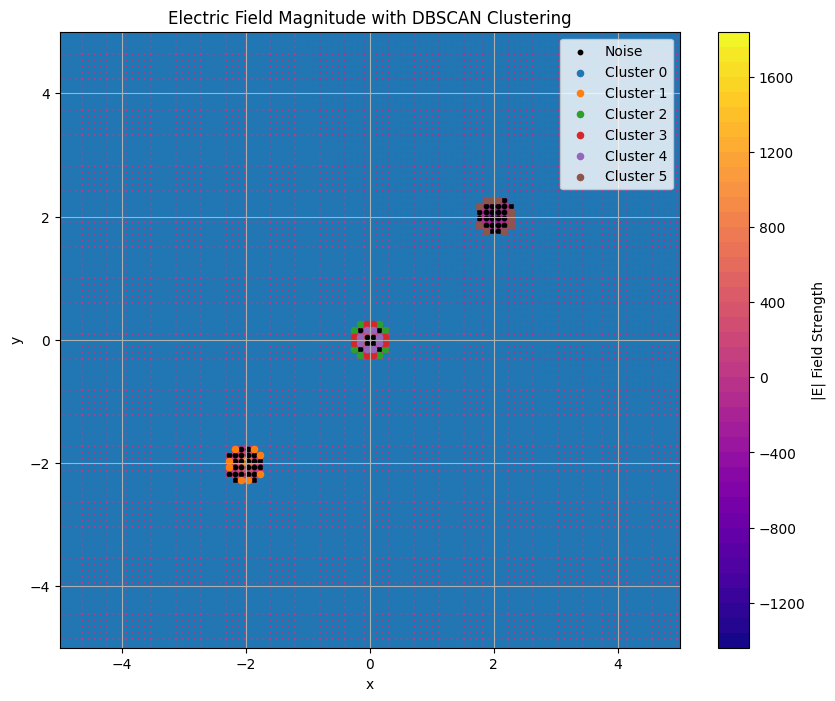

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

# Plot the electric field magnitude as a filled contour map
contour = plt.contourf(X, Y, E, levels=50, cmap='plasma')
plt.colorbar(contour, label='|E| Field Strength')

# Overlay the clustered points with distinct colors for each cluster
# Noise points (label == -1) will be plotted in black
unique_labels = np.unique(labels)
for cluster_label in unique_labels:
    cluster_mask = (labels == cluster_label)
    if cluster_label == -1:
        # Plot noise in black with smaller marker size
        plt.scatter(X.ravel()[cluster_mask], Y.ravel()[cluster_mask],
                    c='k', s=10, label='Noise')
    else:
        plt.scatter(X.ravel()[cluster_mask], Y.ravel()[cluster_mask],
                    s=20, label=f'Cluster {cluster_label}')

plt.title('Electric Field Magnitude with DBSCAN Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()
